In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("priyaadharshinivs062/leukemia-dataset-02")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/leukemia-dataset-02


In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

In [3]:
# Dataset Paths
dataset_base_path = "/kaggle/input/leukemia-dataset-02/archive (1)"
train_dir = os.path.join(dataset_base_path, "train")
test_dir = os.path.join(dataset_base_path, "test")

print("Training Directory:", train_dir)
print("Testing Directory:", test_dir)

# Verify class folders inside the train directory
print("Classes in training directory:", os.listdir(train_dir))


Training Directory: /kaggle/input/leukemia-dataset-02/archive (1)/train
Testing Directory: /kaggle/input/leukemia-dataset-02/archive (1)/test
Classes in training directory: ['CML', 'H', 'ALL', 'AML', 'CLL']


In [4]:
# Class mapping
class_map = {'ALL': 0, 'AML': 1, 'CLL': 2, 'CML': 3, 'H': 4}
classes = list(class_map.keys())

# Function to collect image paths and labels
def collect_data(data_dir):
    image_paths = []
    labels = []
    for class_name, class_label in class_map.items():
        class_folder = os.path.join(data_dir, class_name)
        if os.path.exists(class_folder):
            for file in os.listdir(class_folder):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(class_folder, file))
                    labels.append(class_label)
        else:
            print(f"Directory {class_folder} not found")
    return image_paths, labels

Displaying images from: /kaggle/input/leukemia-dataset-02/archive (1)/train


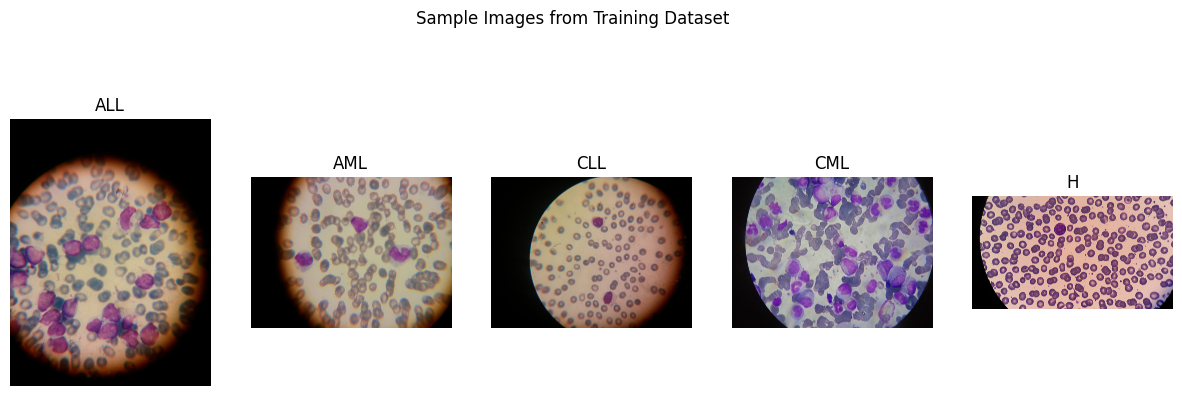

Total training images: 15000
Total testing images: 5000


In [6]:
# Function to count total images in a directory
def count_total_images(directory):
    total_images = 0
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        # Count all image files in the folder
        total_images += len([img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return total_images

# Function to display one image per class
def show_images_from_each_class(directory, title):
    print(f"Displaying images from: {directory}")
    plt.figure(figsize=(15, 5))  # Set the plot size
    for i, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        # List all image files in the folder
        image_files = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if image_files:
            image_path = os.path.join(class_path, image_files[0])
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
            plt.subplot(1, len(classes), i + 1)  # Create a subplot for each class
            plt.imshow(image)
            plt.title(class_name)
            plt.axis("off")  # Remove axis for better visualization
    plt.suptitle(title)
    plt.show()

# Show one image per class
show_images_from_each_class(train_dir, "Sample Images from Training Dataset")

# Count total images in train and test directories
total_train_images = count_total_images(train_dir)
total_test_images = count_total_images(test_dir)

# Print the total number of images
print(f"Total training images: {total_train_images}")
print(f"Total testing images: {total_test_images}")


In [5]:
# Create an ImageDataGenerator for training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize image values to [0,1]
    rotation_range=10,  # Random rotation between -30 and 30 degrees
    width_shift_range=0.05,  # Random horizontal shift
    height_shift_range=0.05,  # Random vertical shift
    shear_range=0.05,  # Random shear transformation
    zoom_range=0.05,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest',  # Filling strategy for missing pixels
    validation_split=0.1  # Use 10% of the training data for validation
)

# Flow training images using the generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to a consistent shape (e.g., 224x224)
    batch_size=32,  # Choose an appropriate batch size
    class_mode='sparse',  # Set to 'sparse' if labels are integers
    subset='training',  # Use the training subset (90% of the data)
    shuffle=True  # Shuffle the data during training
)

# Flow validation images using the generator (10% of the training data)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to a consistent shape (e.g., 224x224)
    batch_size=32,  # Choose an appropriate batch size
    class_mode='sparse',  # Set to 'sparse' if labels are integers
    subset='validation',  # Use the validation subset (10% of the training data)
    shuffle=False  # No need to shuffle the validation set
)

# Create a separate ImageDataGenerator for the test data (with normalization)
test_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize image values to [0,1]
)

# Flow test images using the generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Resize images to a consistent shape (e.g., 224x224)
    batch_size=32,  # Choose an appropriate batch size
    class_mode='sparse',  # Set to 'sparse' if labels are integers
    shuffle=False  # No need to shuffle the test set
)


Found 13500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


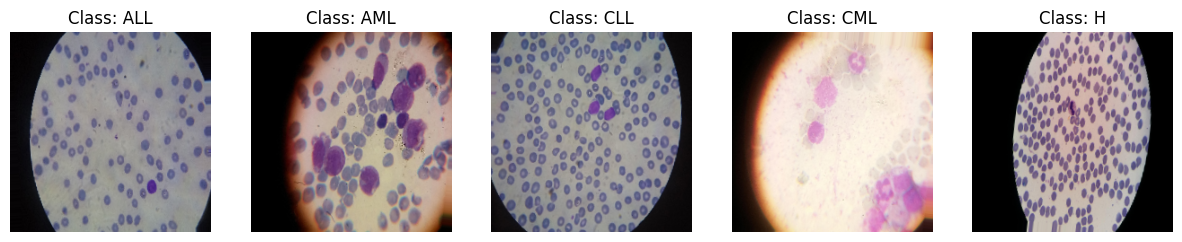

In [8]:
# Function to visualize one image from each class after augmentation
def show_one_image_from_each_class(generator, num_classes=5):
    # Initialize a figure with subplots for each class
    plt.figure(figsize=(15, 5))
    
    # Loop over each class
    for class_idx in range(num_classes):
        # Find the image corresponding to this class
        while True:
            # Get a batch of images and labels
            images, labels = next(generator)
            
            # Check if the batch contains an image from the current class
            if class_idx in labels:
                # Find the index of the image of this class in the batch
                class_image_index = list(labels).index(class_idx)
                
                # Get the corresponding image
                image = images[class_image_index]
                
                # Plot the image
                plt.subplot(1, num_classes, class_idx + 1)  # Create a subplot for each class
                plt.imshow(image)
                plt.title(f"Class: {classes[class_idx]}")
                plt.axis('off')  # Remove axis for better visualization
                break
    
    # Display the image grid
    plt.show()

# Visualize one augmented image from each class
show_one_image_from_each_class(train_generator)


In [9]:
# Clear the session before initializing the model
K.clear_session()

# Load the EfficientNetB0 model without the top layer, to use it as a feature extractor
base_model = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Create the model using the functional API
inputs = layers.Input(shape=(224, 224, 3))  # Input layer
x = base_model(inputs)  # Pass the input through the base model
x = layers.GlobalAveragePooling2D()(x)  # Add a global average pooling layer
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Dense layer with L2 regularization
x = layers.Dropout(0.5)(x)  # Dropout layer
outputs = layers.Dense(len(classes), activation='softmax')(x)  # Output layer

# Create the final model
model = models.Model(inputs, outputs)

# Unfreeze the last 50 layers of the base model
#for layer in base_model.layers[-50:]:
    #layer.trainable = True

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_base (Functional)           │ (None, 7, 7, 1024)          │      87,566,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,698,309 (334.54 MB)

 Trainable params: 131,845 (515.02 KB)

 Non-trainable params: 87,566,464 (334.04 MB)

In [10]:

print(f'Total layers in ConvNeXtBase: {len(base_model.layers)}')


Total layers in ConvNeXtBase: 259


In [11]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model using the data generators
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # You can adjust this based on your dataset size
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


422/422 ━━━━━━━━━━━━━━━━━━━━ 1562s 4s/step - accuracy: 0.4669 - loss: 2.0805 - val_accuracy: 0.5580 - val_loss: 1.1337
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1154s 3s/step - accuracy: 0.5618 - loss: 1.1120 - val_accuracy: 0.6800 - val_loss: 1.0220
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1108s 3s/step - accuracy: 0.5785 - loss: 1.0594 - val_accuracy: 0.4933 - val_loss: 1.0825
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1104s 3s/step - accuracy: 0.5826 - loss: 1.0522 - val_accuracy: 0.5633 - val_loss: 1.0871
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1126s 3s/step - accuracy: 0.5791 - loss: 1.0501 - val_accuracy: 0.5353 - val_loss: 1.0724
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1122s 3s/step - accuracy: 0.5640 - loss: 1.0685 - val_accuracy: 0.4833 - val_loss: 1.0222
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1096s 3s/step - accuracy: 0.5667 - loss: 1.0588 - val_accuracy: 0.5073 - val_loss: 1.0693
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 1145s 3s/step - accuracy: 0.5782 - loss: 1.0369 - val_accurac

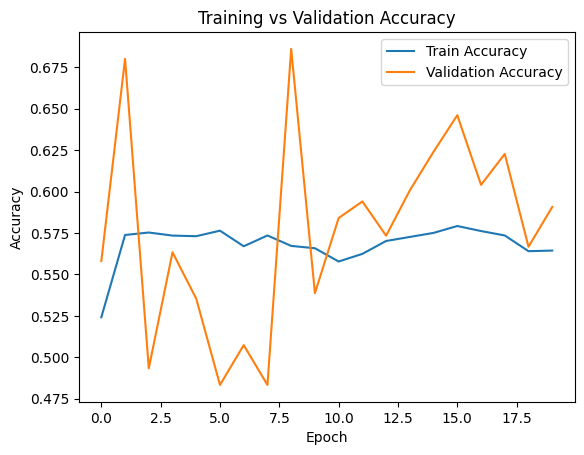

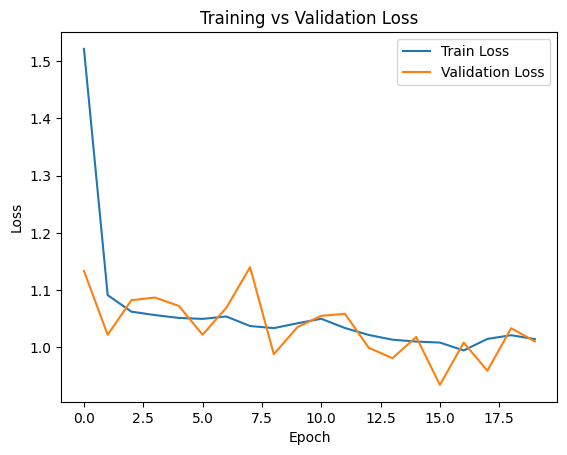

In [12]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [13]:
# Save the model in the Keras format
model.save('ConvNeXtBase_leukemia_classification.keras')


In [14]:
import shutil
from google.colab import files

# Zip the saved model file
shutil.make_archive('ConvNeXtBase_leukemia_classification', 'zip', '.', 'ConvNeXtBase_leukemia_classification.keras') 

'/kaggle/working/ConvNeXtBase_leukemia_classification.zip'

In [6]:

# Load the model
model_path = "/kaggle/input/convnextbase-leukemia/ConvNeXtBase_leukemia_classification.keras"
model = tf.keras.models.load_model(model_path)


In [17]:
# Evaluate model performance on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.3434 - loss: 1.2927
Test Loss: 0.9717592000961304
Test Accuracy: 0.5662000179290771


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 454s 3s/step

Classification Report:
              precision    recall  f1-score   support

         ALL       0.39      0.32      0.35      1000
         AML       0.49      0.14      0.22      1000
         CLL       0.35      0.55      0.43      1000
         CML       0.63      0.83      0.72      1000
           H       0.99      0.99      0.99      1000

    accuracy                           0.57      5000
   macro avg       0.57      0.57      0.54      5000
weighted avg       0.57      0.57      0.54      5000



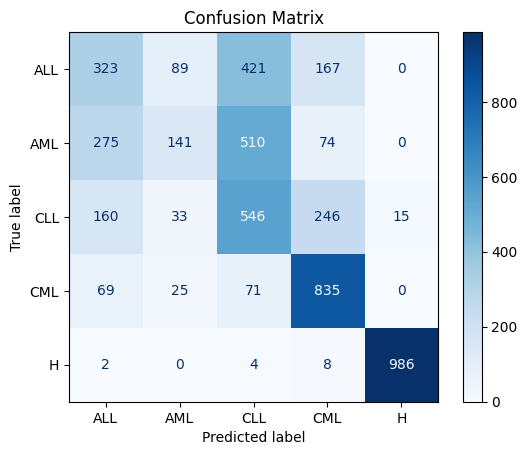

In [7]:
# Generate predictions for the test set
y_true = test_generator.classes  # True labels
y_pred = model.predict(test_generator, verbose=1)  # Model predictions

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot confusion matrix
cm_display.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()